#Привести в порядок вывод рецептов

##Настроить вывод блюд по категории

###Спарсить рецепты с какого-нибудь сайта

#####Закинуть куда-нибудь


In [ ]:
!pip install Pillow==9.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyTelegramBotAPI
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import time
import telebot

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from glob import glob 
import pathlib
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import load_model
from PIL import Image, ImageOps #Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model('/content/drive/MyDrive/Python/attest/Fruits and Vegetables/#36-class classification using ResNet-101.hdf5')

# Load the labels
class_names = open('/content/drive/MyDrive/Python/attest/Fruits and Vegetables/classnames.txt', 'r').readlines()

In [ ]:
def image_helper(data):

# run the inference
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  return class_name

In [ ]:
recipes = pd.read_csv('/content/drive/MyDrive/Python/attest/recipes.csv', encoding='cp1250')
recipes

In [ ]:
def recipe(ingredient):
  ingredient = str(ingredient)
  id = []
  for i in range(len(recipes['ingredients'])):
    result = str(recipes['ingredients'][i]).find(ingredient)
    if result != -1:
      id.append(i)

  r = str(recipes.iloc[id, [1,2,3,4,5,6]].sort_values('rating', ascending=False).head(3))

  return r

In [2]:
from botconfig import TOKEN

In [ ]:
bot = telebot.TeleBot(TOKEN)

@bot.message_handler(content_types=["photo"])
def photografio(message):
  file = bot.get_file(message.photo[-1].file_id)
  bot.send_message(message.from_user.id, 'Фото получил. Обрабатываю!')
  dfile = bot.download_file(file.file_path)
  fimg = message.photo[-1].file_id + '.png'
  with open(fimg, 'wb') as new_file:
    new_file.write(dfile)
  new_file.close()

  image = Image.open(fimg).convert('RGB')
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
  image_array = np.asarray(image)
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
  data[0] = normalized_image_array

  answer = image_helper(data)

  print('Отправлено')
  print(answer)
  bot.send_message(message.from_user.id, answer)

  ingr = ''.join(re.findall('[a-z]', answer))
  print(ingr)
  print(type(ingr))
  recipes_recommendation = recipe(ingr)
  print(recipes_recommendation)
  bot.send_message(message.from_user.id, recipes_recommendation)

bot.infinity_polling()

1/1 [==============================] - 2s 2s/step
Отправлено
pear

pear
<class 'str'>
                             recipeName  rating  totalTimeInSeconds  \
377                Cranberry Pear Sauce     5.0                 NaN   
4822  Crock Pot Corned Beef and Cabbage     5.0                 NaN   
2349                       Cuban Mojito     5.0               120.0   

                       course     cuisine  \
377   [Condiments and Sauces]  [American]   
4822            [Main Dishes]     [Irish]   
2349              [Beverages]     [Cuban]   

                                            ingredients  
377                  [cranberries, pears, honey, water]  
4822  [beef brisket, pearl onions, carrots, parsnips...  
2349  [BACARDI® Rum, spearmint, lime, Sprite Zero, s...  
1/1 [==============================] - 0s 236ms/step
Отправлено
sweetpotato

sweetpotato
<class 'str'>
Empty DataFrame
Columns: [recipeName, rating, totalTimeInSeconds, course, cuisine, ingredients]
Index: []
1/1 [==

2022-11-18 18:35:19,411 (__init__.py:961 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2022-11-18 18:35:19,415 (__init__.py:961 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


#Обучение модели на основе датасета с фотографиями

/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_2.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_5.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_10.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_9.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_8.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_4.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_1.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_6.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_3.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/spinach/Image_7.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/ginger/Image_7.jpg
/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test/ginger/Image

49/49 [==============================] - 813s 16s/step - loss: 18.7283 - accuracy: 0.3876 - val_loss: 0.9538 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 2.0206 - accuracy: 0.5457 
Epoch 2: val_accuracy improved from 0.69231 to 0.75783, saving model to checkpoint/


49/49 [==============================] - 742s 15s/step - loss: 2.0206 - accuracy: 0.5457 - val_loss: 0.9037 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 1.7457 - accuracy: 0.6047 
Epoch 3: val_accuracy improved from 0.75783 to 0.78348, saving model to checkpoint/


49/49 [==============================] - 748s 15s/step - loss: 1.7457 - accuracy: 0.6047 - val_loss: 0.7515 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.6660 
Epoch 4: val_accuracy improved from 0.78348 to 0.83191, saving model to checkpoint/


49/49 [==============================] - 759s 15s/step - loss: 1.4142 - accuracy: 0.6660 - val_loss: 0.5785 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 5/30
49/49 [==============================] - ETA: 0s - loss: 1.3452 - accuracy: 0.6805 
Epoch 5: val_accuracy did not improve from 0.83191
49/49 [==============================] - 712s 15s/step - loss: 1.3452 - accuracy: 0.6805 - val_loss: 0.6977 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 6/30
49/49 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.6971 
Epoch 6: val_accuracy improved from 0.83191 to 0.86040, saving model to checkpoint/


49/49 [==============================] - 734s 15s/step - loss: 1.2994 - accuracy: 0.6971 - val_loss: 0.6110 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 7/30
49/49 [==============================] - ETA: 0s - loss: 1.2543 - accuracy: 0.7180 
Epoch 7: val_accuracy did not improve from 0.86040
49/49 [==============================] - 712s 15s/step - loss: 1.2543 - accuracy: 0.7180 - val_loss: 0.7652 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 8/30
49/49 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.7456 
Epoch 8: val_accuracy did not improve from 0.86040
49/49 [==============================] - 722s 15s/step - loss: 1.0486 - accuracy: 0.7456 - val_loss: 0.6597 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 9/30
49/49 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.7658 
Epoch 9: val_accuracy improved from 0.86040 to 0.87179, saving model to checkpoint/


49/49 [==============================] - 750s 15s/step - loss: 0.9529 - accuracy: 0.7658 - val_loss: 0.6101 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 10/30
49/49 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.7764 
Epoch 10: val_accuracy did not improve from 0.87179
49/49 [==============================] - 707s 14s/step - loss: 1.0069 - accuracy: 0.7764 - val_loss: 0.6957 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 11/30
49/49 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.7899 
Epoch 11: val_accuracy improved from 0.87179 to 0.89744, saving model to checkpoint/


49/49 [==============================] - 742s 15s/step - loss: 0.8484 - accuracy: 0.7899 - val_loss: 0.4334 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 12/30
49/49 [==============================] - ETA: 0s - loss: 0.8502 - accuracy: 0.8062 
Epoch 12: val_accuracy did not improve from 0.89744
49/49 [==============================] - 709s 14s/step - loss: 0.8502 - accuracy: 0.8062 - val_loss: 0.5280 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 13/30
49/49 [==============================] - ETA: 0s - loss: 0.8248 - accuracy: 0.8043 
Epoch 13: val_accuracy did not improve from 0.89744
49/49 [==============================] - 716s 15s/step - loss: 0.8248 - accuracy: 0.8043 - val_loss: 0.5071 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 14/30
49/49 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.7950 
Epoch 14: val_accuracy improved from 0.89744 to 0.90313, saving model to checkpoint/


49/49 [==============================] - 737s 15s/step - loss: 0.8757 - accuracy: 0.7950 - val_loss: 0.4756 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 15/30
49/49 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.8098 
Epoch 15: val_accuracy did not improve from 0.90313
49/49 [==============================] - 696s 14s/step - loss: 0.7373 - accuracy: 0.8098 - val_loss: 0.4200 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 16/30
49/49 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.8226 
Epoch 16: val_accuracy did not improve from 0.90313
49/49 [==============================] - 714s 15s/step - loss: 0.6778 - accuracy: 0.8226 - val_loss: 0.4512 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 17/30
49/49 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.8261 
Epoch 17: val_accuracy improved from 0.90313 to 0.91168, saving model to checkpoint/


49/49 [==============================] - 733s 15s/step - loss: 0.6717 - accuracy: 0.8261 - val_loss: 0.4675 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 18/30
49/49 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.8322 
Epoch 18: val_accuracy improved from 0.91168 to 0.91453, saving model to checkpoint/


49/49 [==============================] - 731s 15s/step - loss: 0.6212 - accuracy: 0.8322 - val_loss: 0.4463 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 19/30
49/49 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.8345 
Epoch 19: val_accuracy did not improve from 0.91453
49/49 [==============================] - 707s 14s/step - loss: 0.6500 - accuracy: 0.8345 - val_loss: 0.3211 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 20/30
49/49 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.8463 
Epoch 20: val_accuracy improved from 0.91453 to 0.91738, saving model to checkpoint/


49/49 [==============================] - 731s 15s/step - loss: 0.5566 - accuracy: 0.8463 - val_loss: 0.4574 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 21/30
49/49 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.8447 
Epoch 21: val_accuracy did not improve from 0.91738
49/49 [==============================] - 710s 15s/step - loss: 0.6074 - accuracy: 0.8447 - val_loss: 0.3949 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 22/30
49/49 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.8495 
Epoch 22: val_accuracy improved from 0.91738 to 0.93162, saving model to checkpoint/


49/49 [==============================] - 735s 15s/step - loss: 0.5638 - accuracy: 0.8495 - val_loss: 0.3184 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 23/30
49/49 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.8697 
Epoch 23: val_accuracy did not improve from 0.93162
49/49 [==============================] - 710s 15s/step - loss: 0.4953 - accuracy: 0.8697 - val_loss: 0.3338 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 24/30
49/49 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8585 
Epoch 24: val_accuracy did not improve from 0.93162
49/49 [==============================] - 705s 14s/step - loss: 0.5169 - accuracy: 0.8585 - val_loss: 0.5908 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 25/30
49/49 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.8598 
Epoch 25: val_accuracy did not improve from 0.93162
49/49 [==============================] - 707s 14s/step - loss: 0.5565 - accuracy: 0.8598 - val_loss: 0.3916 - val_accuracy: 

49/49 [==============================] - 736s 15s/step - loss: 0.4913 - accuracy: 0.8717 - val_loss: 0.4025 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 28/30
49/49 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8884 
Epoch 28: val_accuracy did not improve from 0.94017
49/49 [==============================] - 717s 15s/step - loss: 0.4218 - accuracy: 0.8884 - val_loss: 0.4879 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 29/30
49/49 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8957 
Epoch 29: val_accuracy did not improve from 0.94017
49/49 [==============================] - 721s 15s/step - loss: 0.4312 - accuracy: 0.8957 - val_loss: 0.3772 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 30/30
49/49 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8864 
Epoch 30: val_accuracy did not improve from 0.94017
6/6 [==============================] - 110s 19s/step - loss: 0.3080 - accuracy: 0.9220
test_loss, test accuracy [0.308029145

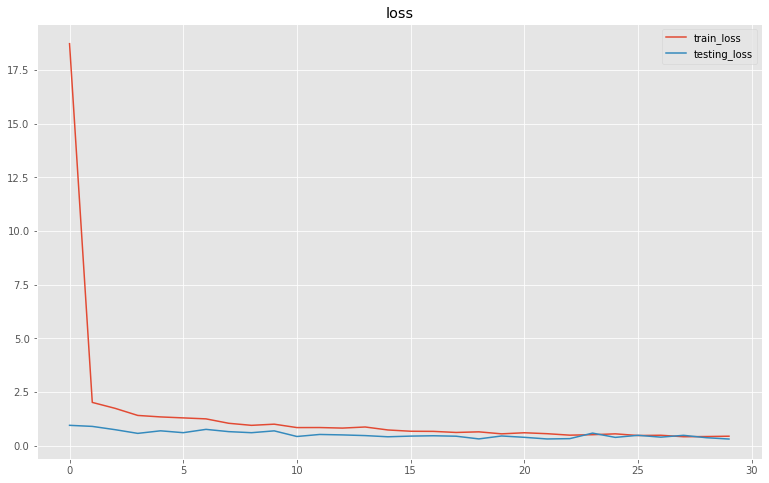

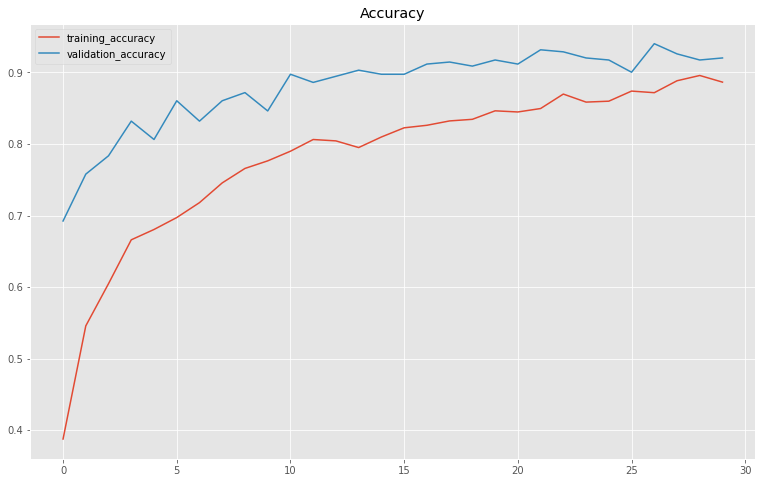

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Python/attest/Fruits and Vegetables'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Loading dataset

train_set = '/content/drive/MyDrive/Python/attest/Fruits and Vegetables/train'
valid_set = '/content/drive/MyDrive/Python/attest/Fruits and Vegetables/validation'
test_set = '/content/drive/MyDrive/Python/attest/Fruits and Vegetables/test'

# getting a list of all the class names
def get_subdirname(path):
    return [name for name in os.listdir(path) # listdir() returns a list containing the names of the entries in the directory given by path. The list is in arbitrary order.
            if os.path.isdir(os.path.join(path, name))]

class_names = get_subdirname(train_set)
class_names

# Data Augmentation

# Generate Training Data
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  shear_range=True,
                                  rotation_range=40,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2
                                )
train_data = train_datagen.flow_from_directory(train_set,
                                                target_size=(224, 224),
                                                batch_size=64,
                                                class_mode='categorical')


# Generate Validation Data
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_data = valid_datagen.flow_from_directory(valid_set,
                                                target_size=(224, 224),
                                                batch_size=64,
                                                class_mode='categorical')


# Generate Test Data
test_datagen = ImageDataGenerator(rescale=1/255.)

test_data = test_datagen.flow_from_directory(test_set,
                                                target_size=(224, 224),
                                                batch_size=64,
                                                class_mode='categorical')

# Initialize the Model 

from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model

resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in resnet_v2.layers:
    layer.trainable = False

base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

#creating a model
model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

model.summary()

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

es = EarlyStopping(monitor='val_accuracy',patience=90,verbose=1,mode='max')
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,min_lr=0.001,patience=15,mode='max',verbose=1)

r = model.fit(train_data,
              epochs= 30,
              batch_size=32,
              validation_data=valid_data,
              callbacks=[es,mc,lr])

result = model.evaluate(test_data,batch_size=64)
print("test_loss, test accuracy",result)

# plotting the loss
plt.figure(figsize=(13, 8))
plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

# plotting the loss
plt.figure(figsize=(13, 8))
plt.plot(r.history['accuracy'],label = 'training_accuracy')
plt.plot(r.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("#36-class classification using ResNet-101.hdf5")

In [ ]:
class_map = train_data.class_indices
labels = list(class_map.keys())

In [ ]:
labels

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [ ]:
classes_file = open ('/content/drive/MyDrive/Python/attest/Fruits and Vegetables/classnames.txt', 'w') 
for element in labels:
     classes_file.write(element)
     classes_file.write('\n')
classes_file.close ()

In [ ]:
recipes = pd.read_csv('/content/drive/MyDrive/Python/attest/RecipeNLG_dataset.csv', encoding='cp1250')
recipes